In [1]:
import sys

sys.path.insert(1, '/Users/users/spirov/ThesisProject/Executable')

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn
from NeuralNets import CustomVaexDataset, printNodes, sc, StraightNetwork,Unet,Stefann
from matplotlib import pyplot as plt

from torch.nn.modules.loss import _Loss



from DataCore import snapshotPath,L


from cycler import cycler




torch.set_default_dtype(torch.float64)

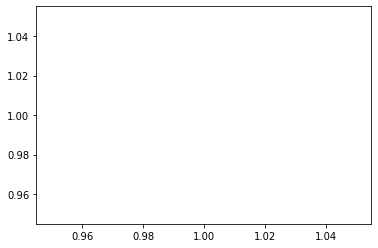

In [2]:


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.rcParams["axes.prop_cycle"] = cycler("color",('indigo','b','r','k','#ff7f0e','g'))
plt.show()

# Using saved model

In [3]:
sc = 3.75e4

learning_rate = 1e-2 #sc/1e5
epochs = 40
bmark = 1e3/sc


In [4]:
GoodPath = "/Users/users/spirov/ThesisProject/Snapshots/FinalModelSnapshot.pt"

model =Unet() #BottleneckNetwork() # StraightNetwork() #
sd = torch.load(GoodPath,map_location=torch.device('cpu'))
model.load_state_dict(sd)

dataPath = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"

dataset = CustomVaexDataset(dataPath)

img, label = dataset.__getitem__(0)

with torch.no_grad():
    mod = model(img.reshape(1,3,len(label)))





In [5]:
mod[0].shape

torch.Size([111992])

Text(0, 0.5, 'residual')

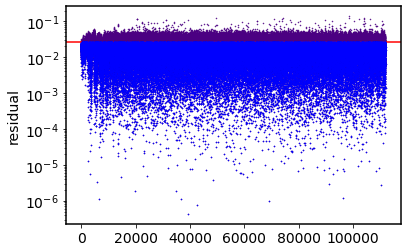

In [6]:
resid = (mod[0]-label).abs()

plt.plot(resid,marker='.',linestyle='',markersize=1)

plt.axhline(bmark,c='r')

filt = resid<(bmark)

plt.plot(np.arange(resid.size()[0])[filt],resid[filt],marker='.',linestyle='',markersize=1)

plt.yscale('log')
plt.ylabel("residual")


### 

Text(0.5, 0, 'residual')

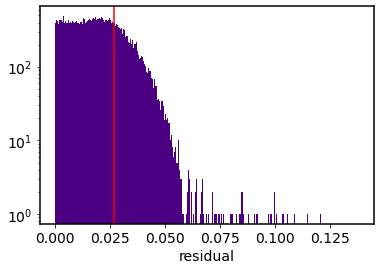

In [7]:
plt.hist(resid,1000)
plt.yscale('log')
plt.axvline(bmark,c='r')
plt.xlabel('residual')

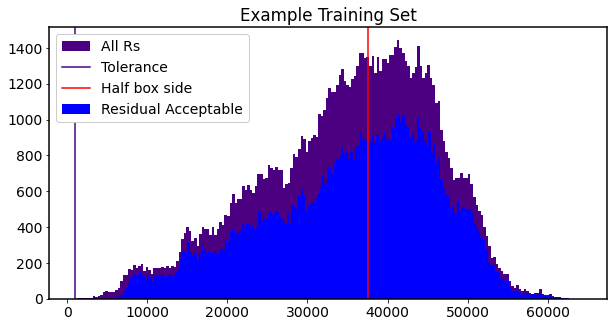

In [8]:
b = 200

plt.figure(figsize=(10,5))
plt.hist(label*sc,b,label='All Rs')
plt.axvline(1e3,label='Tolerance')
plt.axvline(3.75e4,c='r',label="Half box side")
plt.hist(label[filt]*sc,b,label='Residual Acceptable')

plt.legend(loc=2,framealpha=1)
plt.title("Example Training Set")
plt.show()

In [9]:
trus = label[filt].size()[0]
tot = label.size()[0]


print(trus/tot)

0.7300610757911279


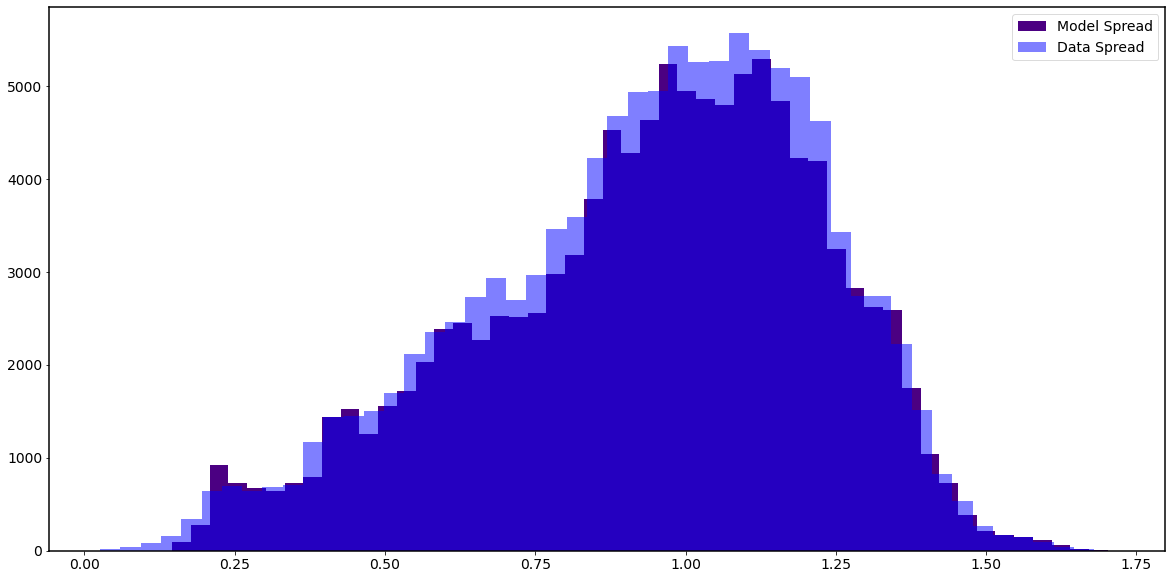

In [10]:
plt.figure(figsize=(20,10))
plt.hist(mod[0],50,label="Model Spread")
plt.hist(label,50,label="Data Spread",alpha=0.5)
plt.legend()
#plt.yscale("log")
plt.show()

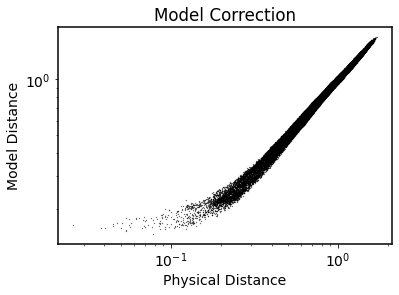

In [11]:
plt.loglog(label,mod[0],'k.',markersize=0.5)
plt.xlabel("Physical Distance")
plt.ylabel("Model Distance")
plt.title("Model Correction")
plt.show()

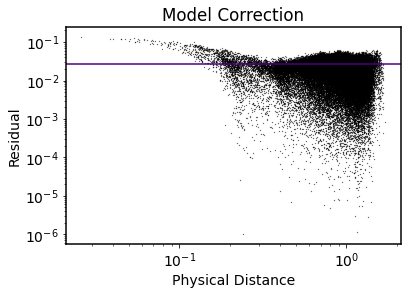

In [12]:
plt.loglog(label,mod[0]-label,'k.',markersize=0.5)
plt.xlabel("Physical Distance")
plt.ylabel("Residual")
plt.title("Model Correction")
plt.axhline(bmark)
plt.show()

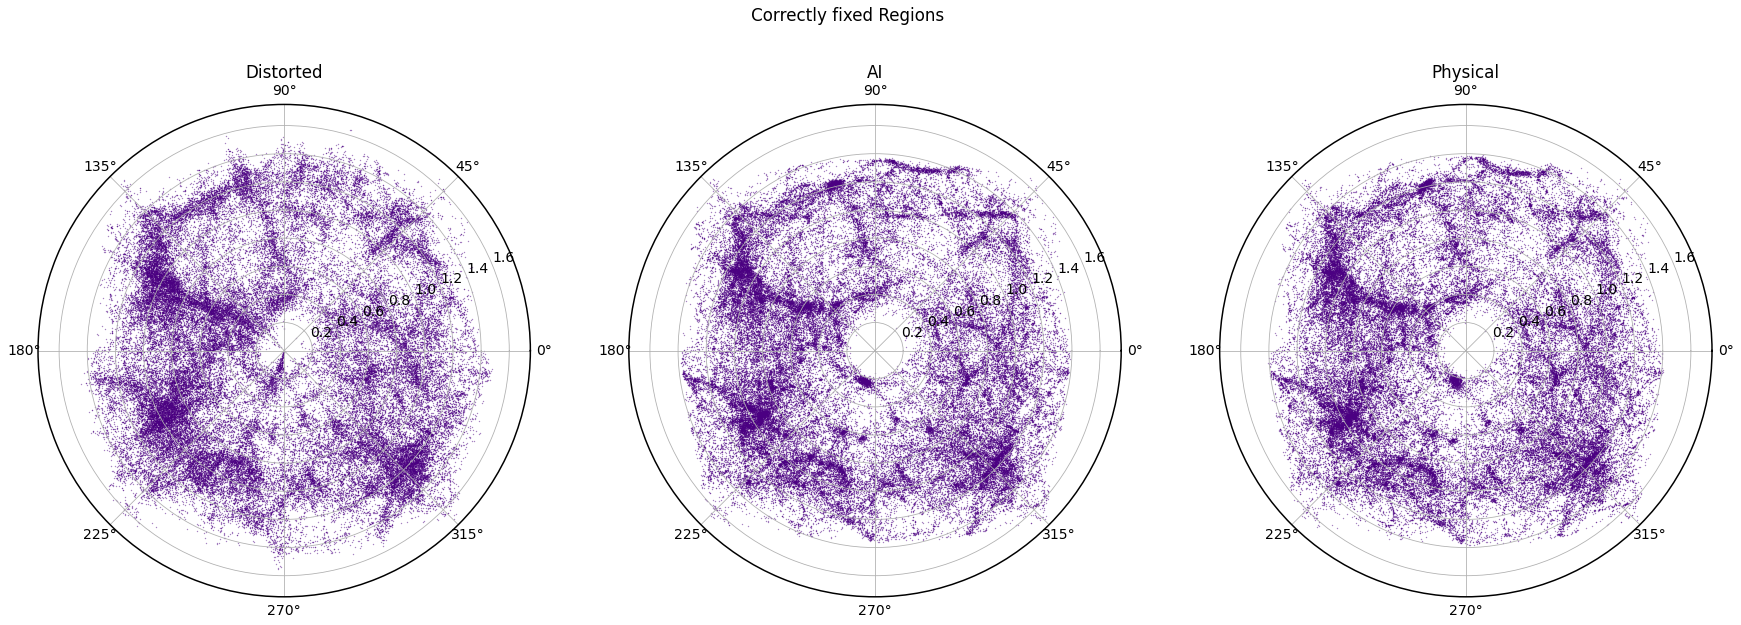

In [13]:
siz = .1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],img[0][filt],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],mod[0][filt],s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],label[filt],s=siz,alpha=0.7)
plt.title("Physical")

plt.suptitle("Correctly fixed Regions")
plt.show()

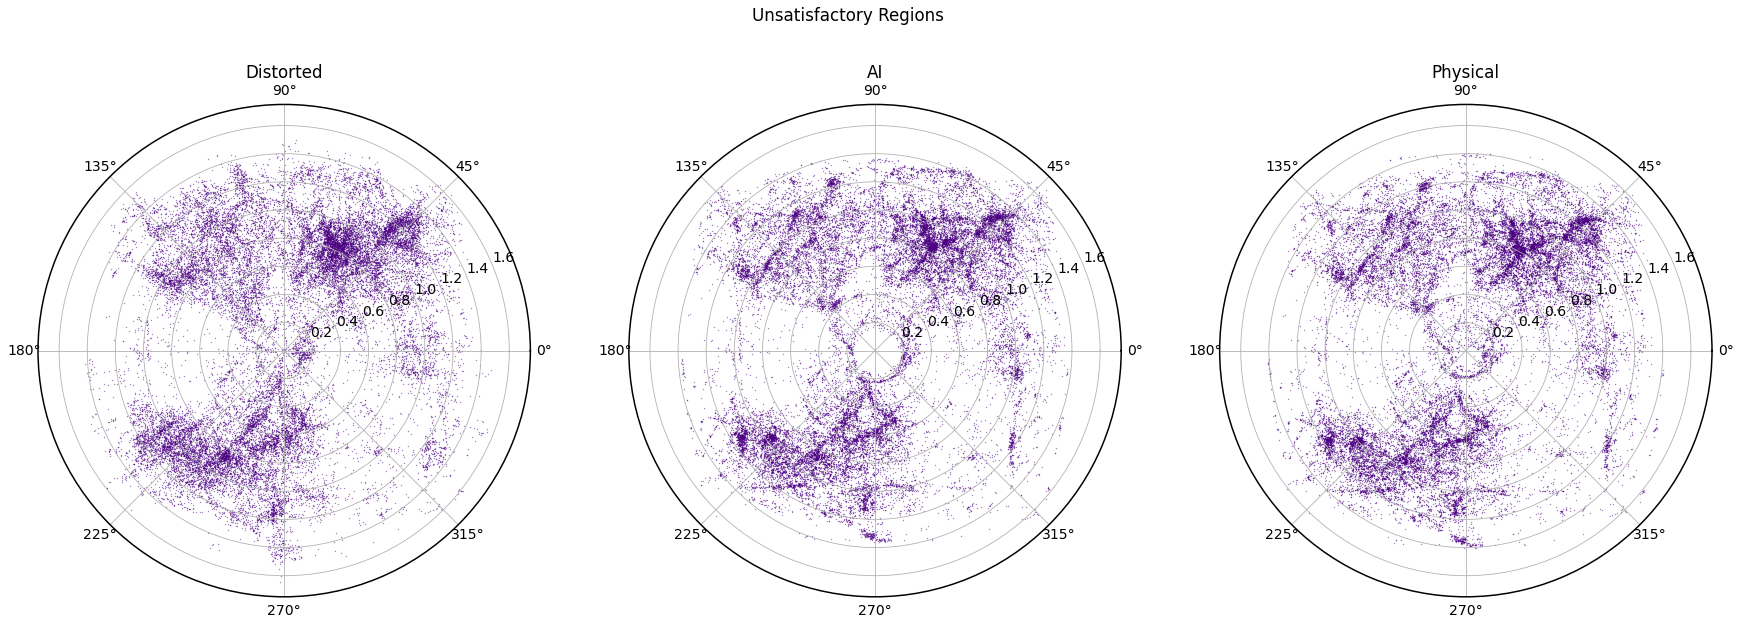

In [14]:
siz = .1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],img[0][~filt],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],mod[0][~filt],s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],label[~filt],s=siz,alpha=0.7)
plt.title("Physical")

plt.suptitle("Unsatisfactory Regions")
plt.show()

In [15]:
dataPath = "/Users/users/spirov/Blk/Nexus Project/Thesis-Project-Cosmic-Web/Data/Testing/"
dataset = CustomVaexDataset(dataPath)

A = []

correct = 0
N=len(dataset)
for i in range(N):
    
    img, label = dataset.__getitem__(i)
    with torch.no_grad():
        mod = model(img.reshape(1,3,len(label)))
        
    resid = (mod[0]-label).abs()
    filt = resid<(bmark)
    correct += ((label - mod[0]).abs() < bmark).type(torch.int).sum().item()
    acc = len(resid[filt])/len(resid)
    A.append(acc)
    if i%10 ==0:
        print(i)
correct /= N

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250


In [16]:
correct/len(label)

0.7235655643929924

In [17]:
np.mean(A)

0.7235655643929924

In [18]:
np.median(A)

0.7594783555968283

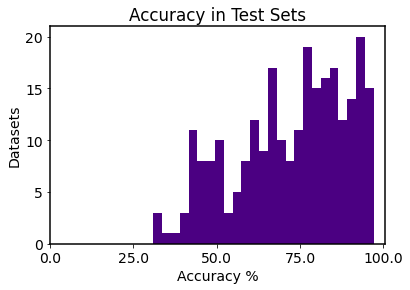

In [19]:
plt.hist(A,25)
plt.title("Accuracy in Test Sets")
plt.xticks(np.linspace(0,1,5),np.linspace(0,100,5))
plt.xlabel("Accuracy %")
plt.ylabel("Datasets")
plt.show()

In [20]:
min(A)

0.31008464890349313

# Bad set

In [21]:
np.where(A == np.min(A))

(array([182]),)

In [22]:
img, label = dataset.__getitem__(182)

with torch.no_grad():
    mod = model(img.reshape(1,3,len(label)))


Text(0, 0.5, 'residual')

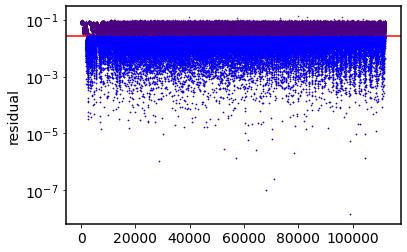

In [23]:
resid = (mod[0]-label).abs()

plt.plot(resid,marker='.',linestyle='',markersize=1)

plt.axhline(bmark,c='r')

filt = resid<(bmark)

plt.plot(np.arange(resid.size()[0])[filt],resid[filt],marker='.',linestyle='',markersize=1)

plt.yscale('log')
plt.ylabel("residual")


### 

Text(0.5, 0, 'residual')

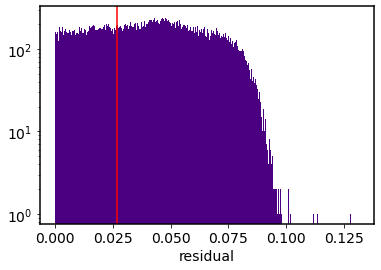

In [24]:
plt.hist(resid,1000)
plt.yscale('log')
plt.axvline(bmark,c='r')
plt.xlabel('residual')

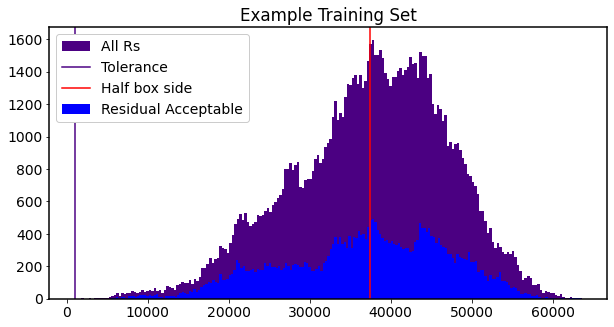

In [25]:
b = 200

plt.figure(figsize=(10,5))
plt.hist(label*sc,b,label='All Rs')
plt.axvline(1e3,label='Tolerance')
plt.axvline(3.75e4,c='r',label="Half box side")
plt.hist(label[filt]*sc,b,label='Residual Acceptable')

plt.legend(loc=2,framealpha=1)
plt.title("Example Training Set")
plt.show()

In [26]:
trus = label[filt].size()[0]
tot = label.size()[0]


print(trus/tot)

0.31008464890349313


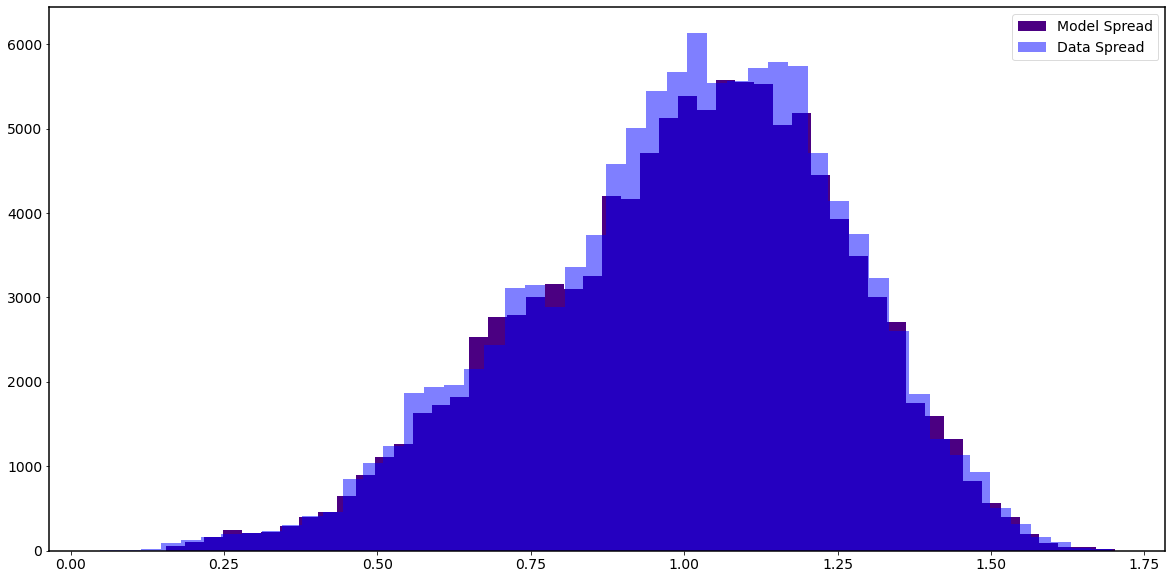

In [27]:
plt.figure(figsize=(20,10))
plt.hist(mod[0],50,label="Model Spread")
plt.hist(label,50,label="Data Spread",alpha=0.5)
plt.legend()
#plt.yscale("log")
plt.show()

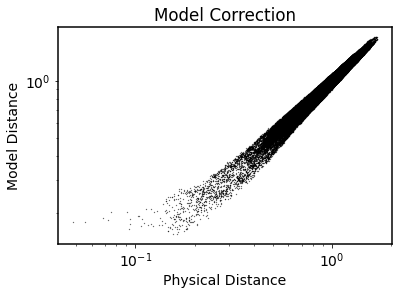

In [28]:
plt.loglog(label,mod[0],'k.',markersize=0.5)
plt.xlabel("Physical Distance")
plt.ylabel("Model Distance")
plt.title("Model Correction")
plt.show()

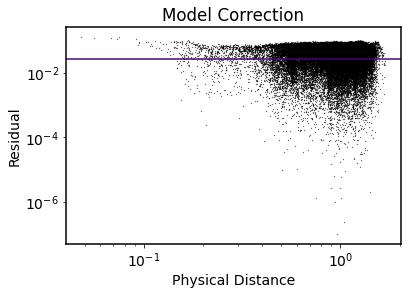

In [29]:
plt.loglog(label,mod[0]-label,'k.',markersize=0.5)
plt.xlabel("Physical Distance")
plt.ylabel("Residual")
plt.title("Model Correction")
plt.axhline(bmark)
plt.show()

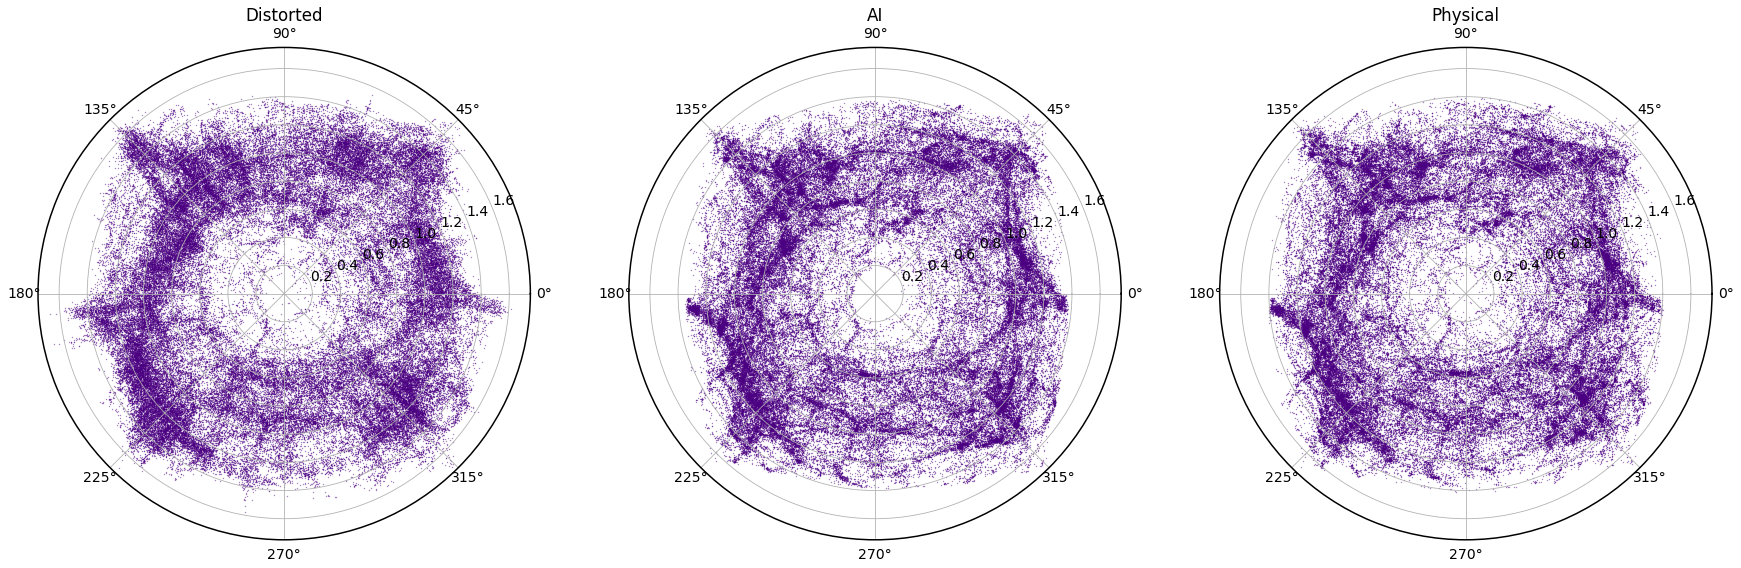

In [30]:
siz = .1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][:],img[0][:],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][:],mod[0][:],s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][:],label[:],s=siz,alpha=0.7)
plt.title("Physical")

plt.show()

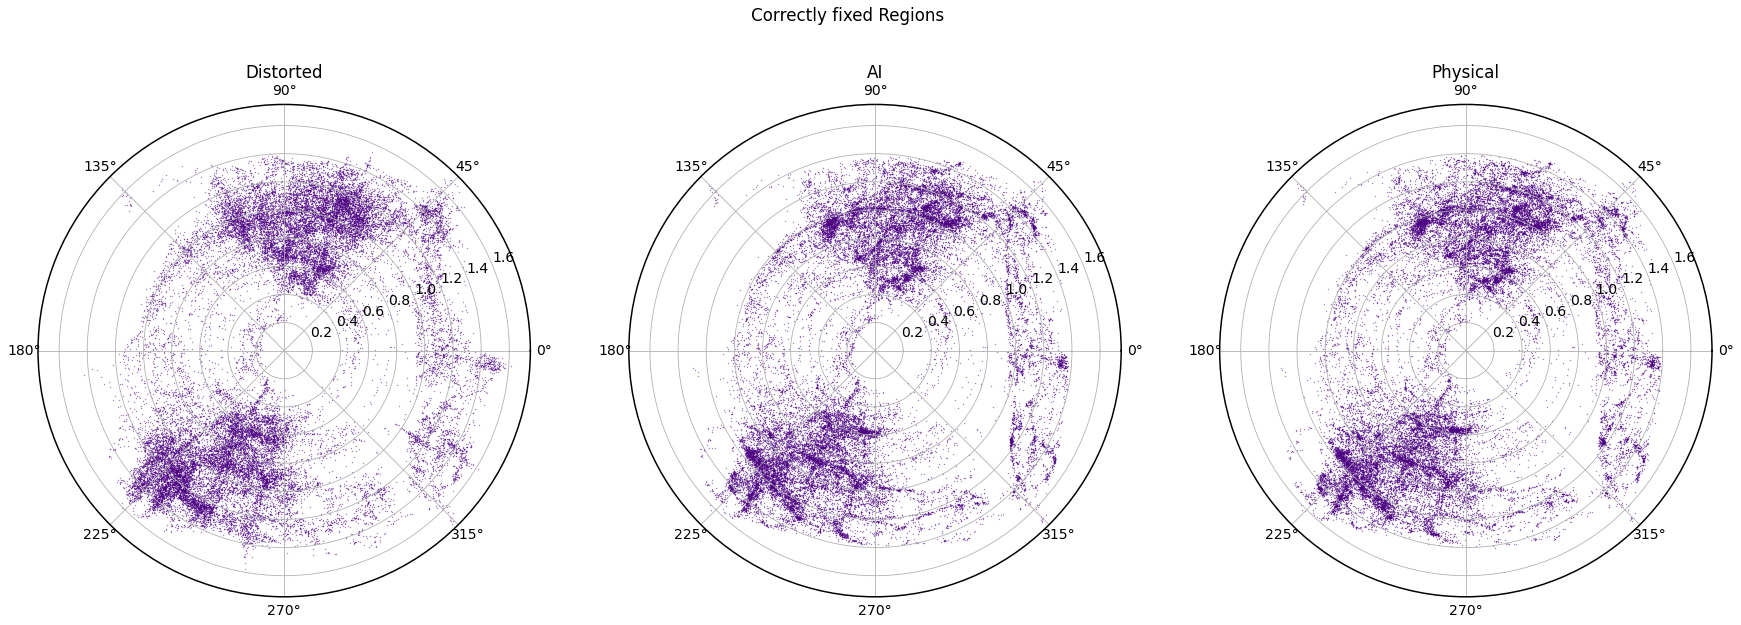

In [31]:
siz = .1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],img[0][filt],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],mod[0][filt],s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][filt],label[filt],s=siz,alpha=0.7)
plt.title("Physical")

plt.suptitle("Correctly fixed Regions")
plt.show()

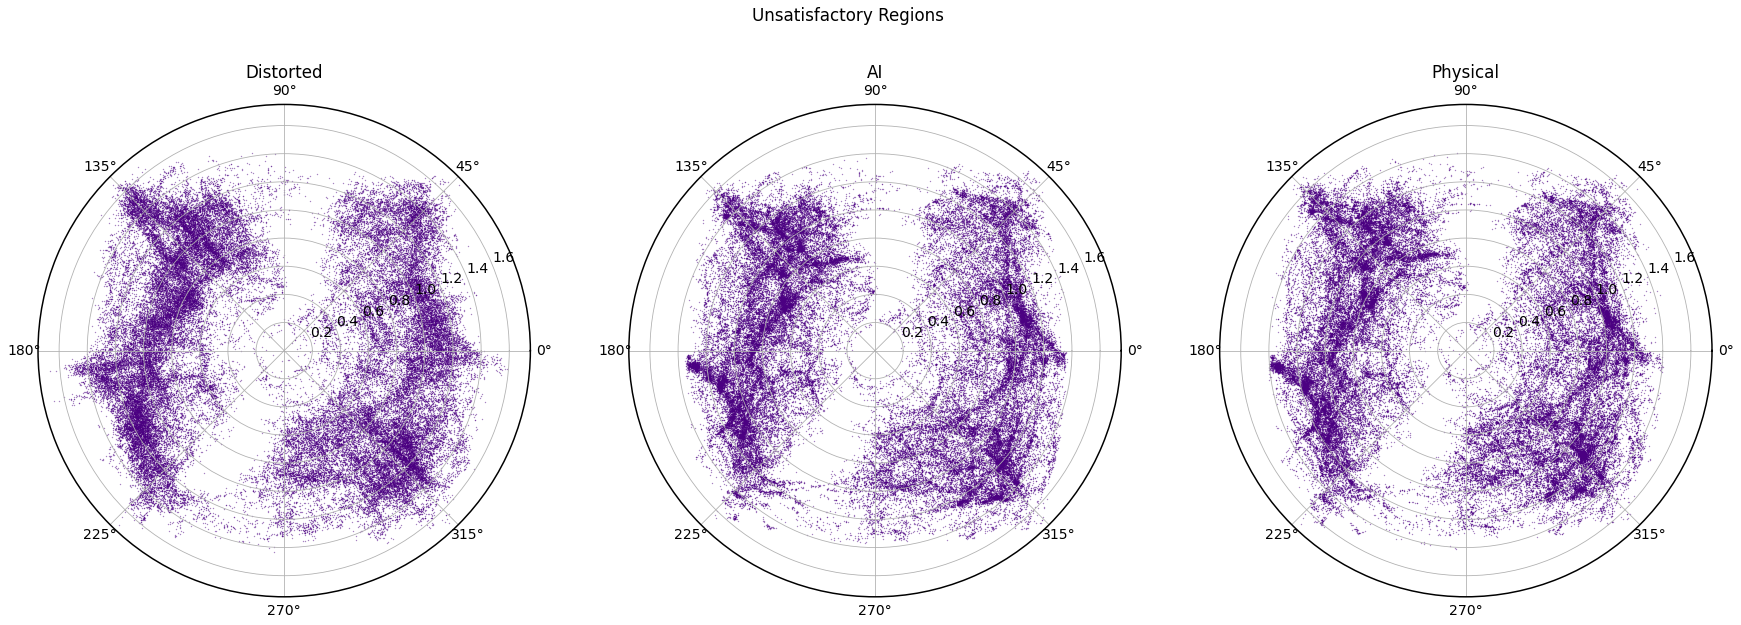

In [32]:
siz = .1

plt.figure(figsize=(30,10))
plt.subplot(131,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],img[0][~filt],s=siz,alpha=0.7)
plt.title("Distorted")
plt.subplot(132,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],mod[0][~filt],s=siz,alpha=0.7)
plt.title("AI")
plt.subplot(133,projection="polar")
plt.ylim(0,1.75)
plt.scatter(img[2][~filt],label[~filt],s=siz,alpha=0.7)
plt.title("Physical")

plt.suptitle("Unsatisfactory Regions")
plt.show()